Oversampling > 2x suggested for reliable results in Fresnel propagation.


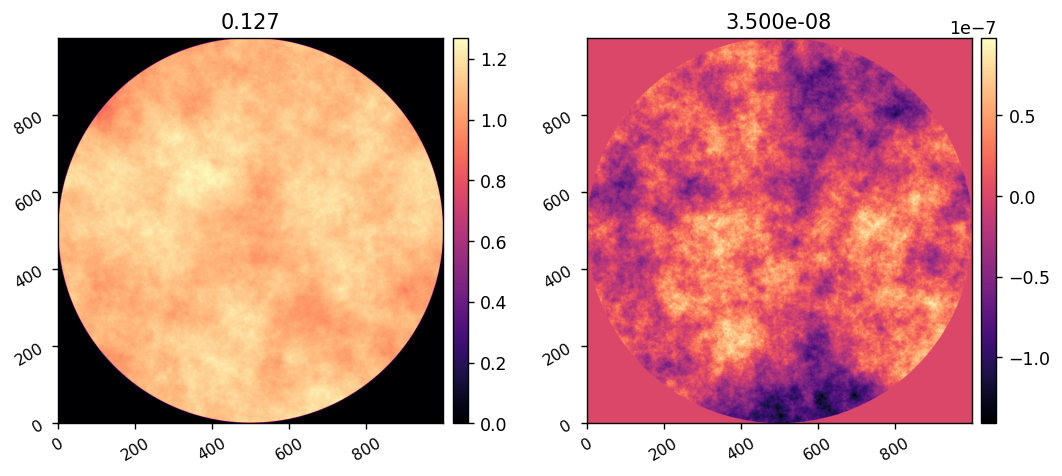

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import copy
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
from importlib import reload

from scipy.optimize import minimize

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.ad_efc as ad_efc
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

reload(utils)
WFE, mask = utils.generate_wfe(diam=10*u.mm,
                                npix=1000, oversample=1,
                                wavelength=650*u.nm,
                                opd_index=2.75, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*650e-9/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')


Oversampling > 2x suggested for reliable results in Fresnel propagation.


951


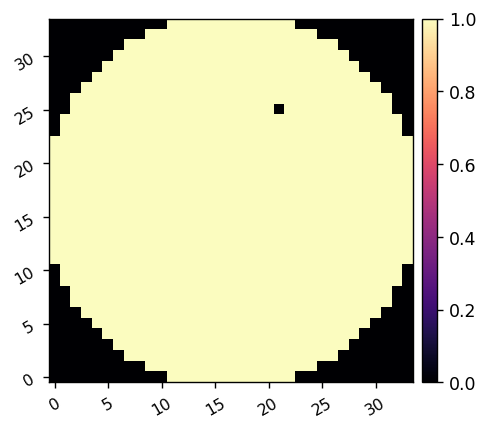

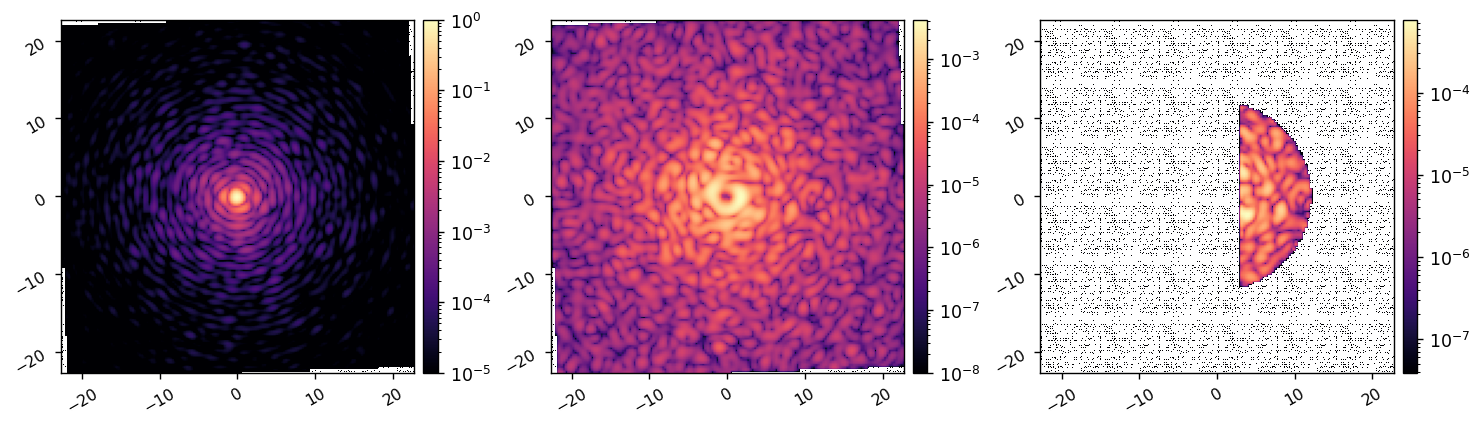

In [2]:
reload(ad_scoob)
m = ad_scoob.MODEL()
# m = ad_scoob.MODEL(use_dead_act=False)
m.WFE = WFE
print(m.Nacts)
imshow1(m.dm_mask)
m.npsf = 150
m.det_rotation = 178
m.psf_pixelscale_lamD = 0.303

m.create_control_mask()

acts = np.zeros(m.Nacts)

ref_psf = m.snap(acts, use_vortex=False)
m.Imax_ref = xp.max(ref_psf)
ref_coro_im = m.snap(acts)

imshow3(ref_psf/m.Imax_ref, ref_coro_im, ref_coro_im*m.control_mask,
        pxscl=m.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-8)


0.08515731158488588 0.0 0.08515731158488588 1.0
0.0


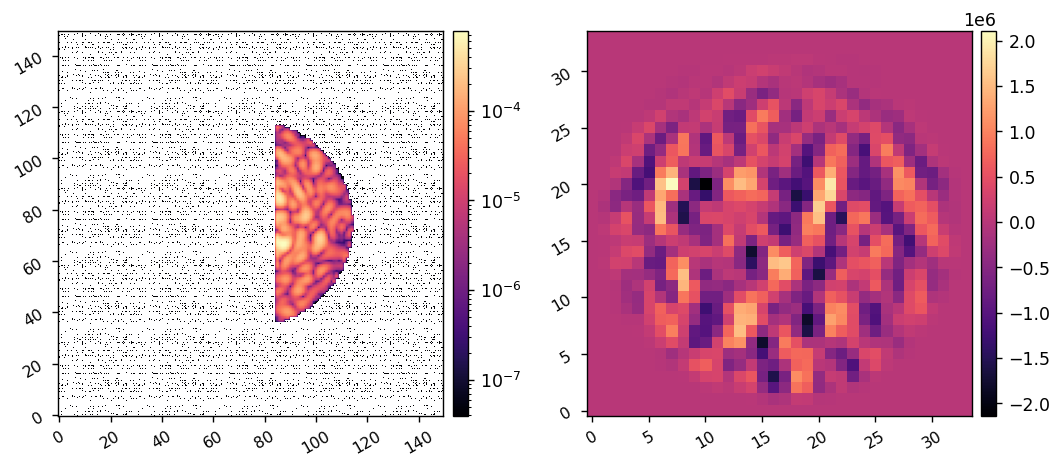

In [3]:
reload(ad_scoob)

acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * m.control_mask
r_cond = 1e-2

del_acts = np.zeros(m.Nacts)
J, dJ_dA = ad_scoob.val_and_grad(del_acts, m, acts, E_ab, r_cond, verbose=True)

dm_grad = ad_scoob.acts_to_command(dJ_dA, m.dm_mask)
print(dm_grad[25,21])
imshow2(xp.abs(E_ab)**2, dm_grad, lognorm1=True)

In [4]:
reload(ad_scoob)
acts = np.zeros(m.Nacts)
# acts = fits.getdata('data/ad_test_acts.fits')

E_ab = m.forward(acts) * m.control_mask
r_cond = 1e-3
bfgs_tol = 1e-3
bfgs_opts = {
    'disp':True,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

del_acts0 = np.zeros(m.Nacts)
res = minimize(ad_scoob.val_and_grad, 
                jac=True, 
                x0=del_acts0,
                args=(m, acts, E_ab, r_cond, True), 
                method='L-BFGS-B',
                tol=bfgs_tol,
                options=bfgs_opts,
                )


0.08515731158488588 0.0 0.08515731158488588 1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.14274D+06
0.0024685266415682247 2495701154.760923 0.08515731158488588 29306950963.049664
0.0045649763025863 26.049980012748474 0.08515731158488588 305.95781506182897


 This problem is unconstrained.


0.048049062356549724 1.6371353667135533 0.08515731158488588 19.789075038968203
0.4140986679030552 0.16570755342640023 0.08515731158488588 6.8086487294927975
2.10687755892623 0.014824332405654117 0.08515731158488588 24.915087757519743
1.0429946165319983 0.0006455301818539683 0.08515731158488588 12.255437933518353
0.016936915614162874 3.103341856196516e-05 0.08515731158488588 0.1992541652258594

At iterate    1    f=  1.99254D-01    |proj g|=  9.41721D+05
0.006485573231215398 3.104331032958168e-05 0.08515731158488588 0.0765244512803711

At iterate    2    f=  7.65245D-02    |proj g|=  2.93737D+05
0.0032496531832000427 3.794950560180448e-05 0.08515731158488588 0.038606229196476265

At iterate    3    f=  3.86062D-02    |proj g|=  1.85710D+05
0.002059557980449235 4.3802050126357124e-05 0.08515731158488588 0.02469969978419218

At iterate    4    f=  2.46997D-02    |proj g|=  1.09721D+05
0.0014837239163541759 5.00012069097482e-05 0.08515731158488588 0.01801049251930749

At iterate    5    f=

In [68]:
del_command[25,21]

array(1.82229695e-10)

In [7]:
del_command[25,21]

array(0.)

5.080985178095816e-05 2.444728563889864e-07


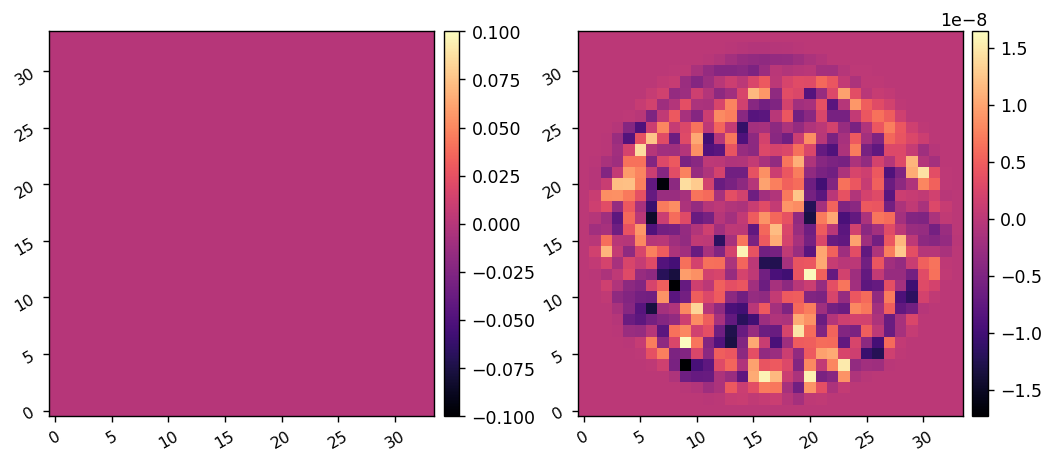

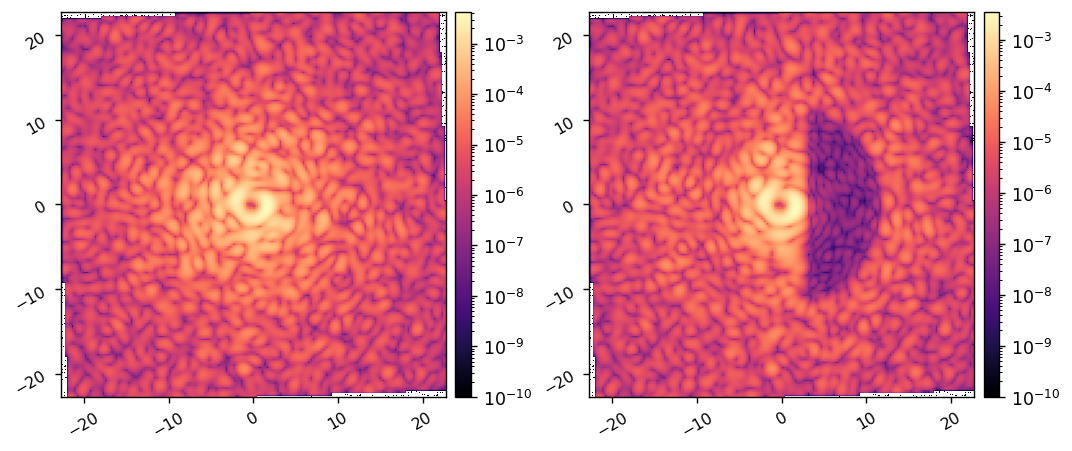

In [6]:
old_command = ad_scoob.acts_to_command(acts, m.dm_mask)
del_command = ad_scoob.acts_to_command(res.x, m.dm_mask)
old_im = m.snap(acts)
new_im = m.snap(acts + res.x)
print(xp.mean(old_im[m.control_mask]), xp.mean(new_im[m.control_mask]))

imshow2(old_command, del_command)
imshow2(old_im, new_im, lognorm=True, pxscl=m.psf_pixelscale_lamD, vmin1=1e-10, vmin2=1e-10)

In [6]:
utils.save_fits('data/ad_test_acts.fits', res.x)

Saved data to:  data/ad_test_acts.fits


In [8]:
all_ims = []
all_efs = []
all_commands = []


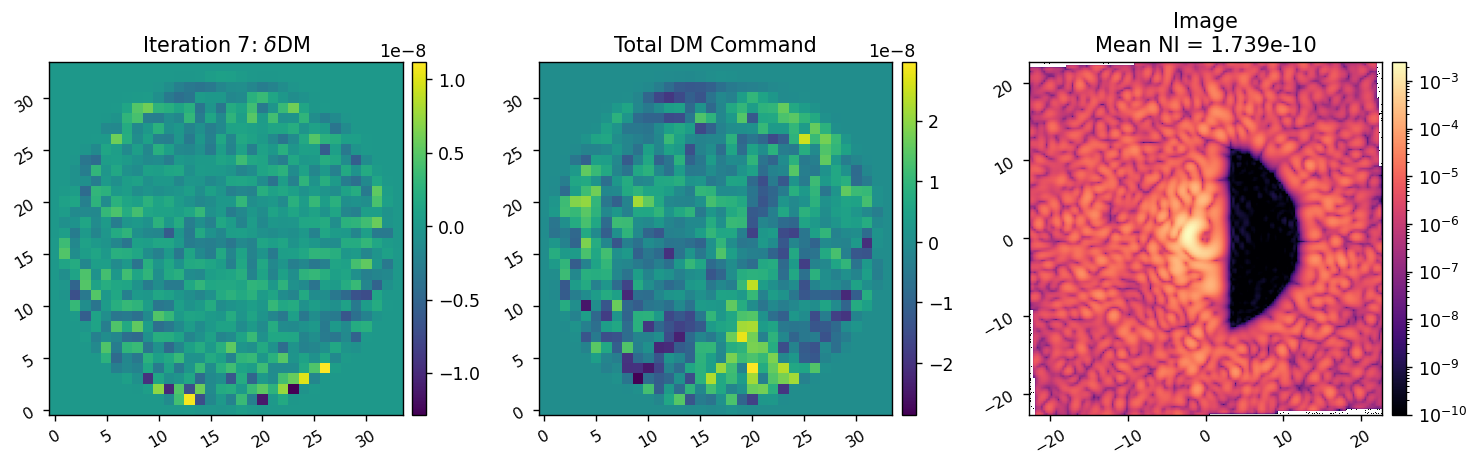

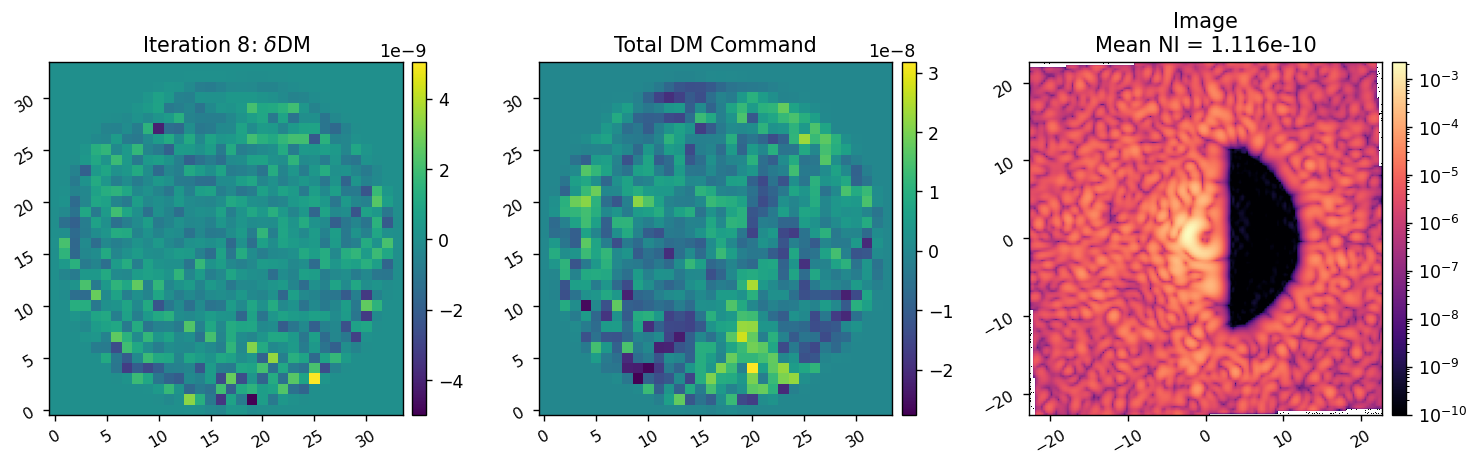

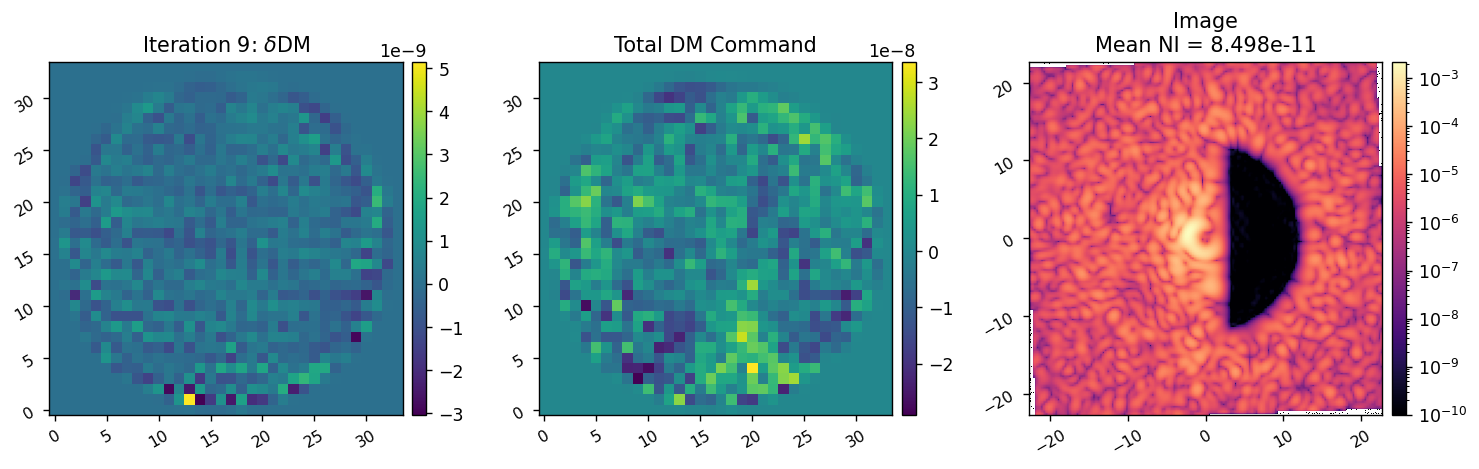

In [11]:
reload(ad_scoob)
reload(ad_efc)

# r_cond = 1e-2
r_cond = 5e-3
# r_cond = 1e-4
r_cond = 1e-5

bfgs_tol = 1e-2
bfgs_tol = 1e-3
# bfgs_tol = 1e-4
bfgs_tol = 1e-5

bfgs_opts = {
    'disp':False,
    # 'ftol':1e-6,
    # 'gtol':1e-6,
}

all_ims, all_efs, all_commands = ad_efc.sim(m, ad_scoob.val_and_grad,
                                            Nitr=3, 
                                            reg_cond=r_cond,
                                            bfgs_tol=bfgs_tol,
                                            bfgs_opts=bfgs_opts,
                                            gain=1,
                                            all_ims=all_ims,
                                            all_efs=all_efs,
                                            all_commands=all_commands,
                                            )

In [15]:
print(all_commands[-1][25,21])

0.0
